### Etymology Prefix Suffix Analysis

In [1]:
import pandas as pd
import numpy as np
import glob
import re

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

#### Nişanyan

In [3]:
df_word_plus_nisanyan = pd.read_excel("/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/All/Nisanyan Words Contain Plus.xlsx")
df_word_plus_nisanyan

,term,related_lang,related_term
0,+ark,Fransızca,+arque
1,+arşi,Fransızca,+archie
2,+faj,Fransızca ve İngilizce,+phage
3,+gam,Fransızca,+game
4,+gen,Fransızca,+gone
...,...,...,...
150,tri+,Fransızca ve İngilizce,tri+
151,trop(o)+,Fransızca ve İngilizce,tropo+
152,üni+,Fransızca ve İngilizce,uni+
153,vaz(o)+,Fransızca ve İngilizce,vaso+


In [4]:
def remove(x):
    try:
        x = x.replace("\n","")
        x = x.replace("\r","")
        x = x.strip()
    except:
        x = x
    return x

In [5]:
df_word_plus_nisanyan["term"] = df_word_plus_nisanyan["term"].apply(lambda x: remove(x))
df_word_plus_nisanyan["related_lang"] = df_word_plus_nisanyan["related_lang"].apply(lambda x: remove(x))
df_word_plus_nisanyan["related_term"] = df_word_plus_nisanyan["related_term"].apply(lambda x: remove(x))
df_word_plus_nisanyan

,term,related_lang,related_term
0,+ark,Fransızca,+arque
1,+arşi,Fransızca,+archie
2,+faj,Fransızca ve İngilizce,+phage
3,+gam,Fransızca,+game
4,+gen,Fransızca,+gone
...,...,...,...
150,tri+,Fransızca ve İngilizce,tri+
151,trop(o)+,Fransızca ve İngilizce,tropo+
152,üni+,Fransızca ve İngilizce,uni+
153,vaz(o)+,Fransızca ve İngilizce,vaso+


In [ ]:
df_word = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Turkish/Result/Word/Merge/Word_Merge2.xlsx")
#df_word = df_word.head(10000)
df_word

In [ ]:
disable_term_list = ["+ark","+gen","+gon","di+","+men","deka+","desi+","bis+","end(o)+","fil(o)+","mili+","ö+","or(o)+","pan(to)+","poli+","port+","post+","vaz(o)+"]

In [ ]:
set_plus_term = set(df_word_plus_nisanyan.loc[:,"term"].values.tolist())
set_disable_term = set(disable_term_list)

In [ ]:
df_term_diff = pd.DataFrame(set_plus_term.difference(set_disable_term), columns=["term"])
df_term_diff

In [ ]:
word_list = df_term_diff.loc[:,"term"].values.tolist()

In [ ]:
df_word_result = pd.DataFrame()
for i in word_list:
    if i.startswith("+"):
        j = i.lstrip("+")
        word_in_video = df_word[df_word.word.str.contains(fr"{j}(?:$)", na=True)]  # string+ext=> word
        word_in_video.insert(0,"term",i)
    elif i.endswith("+"):
        j = i.rstrip("+")
        word_in_video = df_word[df_word.word.str.contains(fr"(?:^){j}", na=True)]  # ext+string=> word
        word_in_video.insert(0,"term",i)
    else:
        pass
    #word_in_video.insert(0,"word_ext",i)
    df_word_result = pd.concat([df_word_result,word_in_video], axis=0)
#df_word_result = df_word_result.sort_values(by="frequency", ascending=False)
df_word_result.reset_index(drop=True, inplace=True)
df_word_result   

In [ ]:
df_pre_suff_nis_merge = pd.merge(df_word_result,df_word_plus_nisanyan, how="inner", on="term")
df_pre_suff_nis_merge

In [ ]:
df_pre_suff_nis_merge.word.nunique()

In [ ]:
df_pre_suff_nis_merge.to_excel("Nisanyan_Prefix_Suffix_Term_In_Word.xlsx", index=False)

##### SparkNLP Lemma

In [ ]:
df_spark_lemma = pd.read_json("/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/All/wR3tE0i-zc6Pl8revsMq4.json")  # lemma result
df_spark_lemma = df_spark_lemma.loc[:,["lem","token"]]
df_spark_lemma.rename(columns={"token":"word"}, inplace=True)
df_spark_lemma

In [ ]:
df_spark_lemma.lem.nunique()

In [ ]:
df_pre_suff_nis_merge = pd.read_excel("Nisanyan_Prefix_Suffix_Term_In_Word.xlsx")
df_pre_suff_nis_merge

In [ ]:
df_lemma_merge = pd.merge(df_pre_suff_nis_merge,df_spark_lemma, how="inner", on="word")
df_lemma_merge.drop_duplicates(inplace=True)
df_lemma_merge

In [ ]:
df_lemma_merge.drop_duplicates(subset="lem", inplace=True)
df_lemma_merge.reset_index(drop=True, inplace=True)
df_lemma_merge

In [ ]:
df_lemma_merge.to_excel("Nisanyan_Prefix_Suffix_Term_In_Word_Lemma_Process.xlsx", index=False)

#### Etymology Word Prefix Suffix Analysis

In [61]:
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False
suffix = True  # True, False

In [3]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [4]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

In [5]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
1005970,karnaya,5
1005971,dörtlümüzün,5
1005972,karnavalınız,5
1005973,hurmanın,5


In [6]:
df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()}_{lang_pair.lower().capitalize()}_Shared_Vocabulary.xlsx")
#df_pair = df_pair.head(200)
df_pair

,dict_entry_main,english_word
0,abaküs,abacus
1,abandone,abandon
2,abanoz,ebony
3,abdomen,abdomen
4,abluka,blockade
...,...,...
2068,zodyak,zodiac
2069,zombi,zombie
2070,zooloji,zoology
2071,zoolojik,zoological


In [7]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [8]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=True, suffix_word=False)
df_prefix_suffix_word

,search_word,word,frequency
0,abaküs,abaküs,158
1,abaküs,abaküsü,20
2,abaküs,abaküsüm,14
3,abaküs,abaküsünü,14
4,abaküs,abaküsle,10
...,...,...,...
97590,zum,zumanın,6
97591,zum,zumanityi,5
97592,zum,zumbidir,5
97593,zum,zumluyor,5


In [9]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,abaküs,abaküs,158,+
1,abaküs,abaküsü,20,+ü
2,abaküs,abaküsüm,14,+üm
3,abaküs,abaküsünü,14,+ünü
4,abaküs,abaküsle,10,+le
...,...,...,...,...
97590,zum,zumanın,6,+anın
97591,zum,zumanityi,5,+anityi
97592,zum,zumbidir,5,+bidir
97593,zum,zumluyor,5,+luyor


In [27]:
df_prefix_suffix.search_word.nunique()

2010

In [28]:
df_prefix_suffix.word.nunique()

86658

In [41]:
df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [42]:
df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,abaküs,abaküs,158,+
1,abaküs,abaküsü,20,+ü
2,abaküs,abaküsüm,14,+üm
3,abaküs,abaküsünü,14,+ünü
4,abaküs,abaküsle,10,+le
...,...,...,...,...
97590,zum,zumanın,6,+anın
97591,zum,zumanityi,5,+anityi
97592,zum,zumbidir,5,+bidir
97593,zum,zumluyor,5,+luyor


In [50]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abaküs,abaküs,158,+,0
1,abaküs,abaküsü,20,+ü,1
2,abaküs,abaküsüm,14,+üm,2
3,abaküs,abaküsünü,14,+ünü,3
4,abaküs,abaküsle,10,+le,2
...,...,...,...,...,...
97590,zum,zumanın,6,+anın,4
97591,zum,zumanityi,5,+anityi,6
97592,zum,zumbidir,5,+bidir,5
97593,zum,zumluyor,5,+luyor,5


In [53]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

5

In [54]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= (prefix_suffix_mean+1)]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abaküs,abaküs,158,+,0
1,abaküs,abaküsü,20,+ü,1
2,abaküs,abaküsüm,14,+üm,2
3,abaküs,abaküsünü,14,+ünü,3
4,abaküs,abaküsle,10,+le,2
...,...,...,...,...,...
97588,zum,zummerin,6,+merin,5
97590,zum,zumanın,6,+anın,4
97592,zum,zumbidir,5,+bidir,5
97593,zum,zumluyor,5,+luyor,5


In [55]:
df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [56]:
#df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abaküs,abaküs,158,+,0
1,abaküs,abaküsü,20,+ü,1
2,abaküs,abaküsüm,14,+üm,2
3,abaküs,abaküsünü,14,+ünü,3
4,abaküs,abaküsle,10,+le,2
...,...,...,...,...,...
55951,zum,zummerin,6,+merin,5
55952,zum,zumanın,6,+anın,4
55953,zum,zumbidir,5,+bidir,5
55954,zum,zumluyor,5,+luyor,5


In [57]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,2063
1,+ler,608
2,+i,608
3,+lar,607
4,+a,579
...,...,...
11060,+insky,1
11061,+insiz,1
11062,+insde,1
11063,+ins,1


In [63]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

55956

In [64]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,2063,3.686825
1,+ler,608,1.086568
2,+i,608,1.086568
3,+lar,607,1.084781
4,+a,579,1.034742
...,...,...,...
11060,+insky,1,0.001787
11061,+insiz,1,0.001787
11062,+insde,1,0.001787
11063,+ins,1,0.001787


In [65]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,2063,3.686825,3.686825
1,+ler,608,1.086568,4.773393
2,+i,608,1.086568,5.859961
3,+lar,607,1.084781,6.944742
4,+a,579,1.034742,7.979484
...,...,...,...,...
11060,+insky,1,0.001787,99.992689
11061,+insiz,1,0.001787,99.994476
11062,+insde,1,0.001787,99.996263
11063,+ins,1,0.001787,99.998050


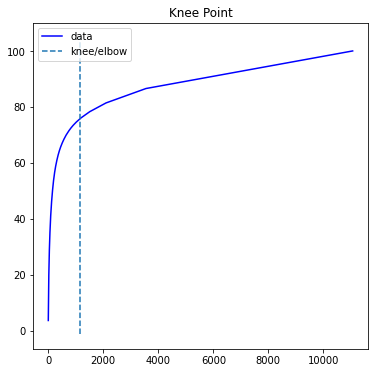

In [66]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [67]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

76

In [83]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,2063,3.686825,3.686825
1,+ler,608,1.086568,4.773393
2,+i,608,1.086568,5.859961
3,+lar,607,1.084781,6.944742
4,+a,579,1.034742,7.979484
...,...,...,...,...
1174,+erım,4,0.007149,75.966827
1175,+süne,4,0.007149,75.973975
1176,+ceden,4,0.007149,75.981124
1177,+kmiş,4,0.007149,75.988272


In [84]:
## Option
#df_prefix_suffix_knee = df_prefix_suffix_knee[df_prefix_suffix_knee.frequency >5]
#df_prefix_suffix_knee

In [85]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [86]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [87]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [88]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [89]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abaküs,abaküs,158,+,0
1,abaküs,abaküse,6,+e,1
2,abaküs,abaküsle,10,+le,2
3,abaküs,abaküsler,7,+ler,3
4,abaküs,abaküsü,20,+ü,1
...,...,...,...,...,...
42475,şırınga,şırıngasıyla,12,+sıyla,5
42476,şırınga,şırıngaya,160,+ya,2
42477,şırınga,şırıngaydı,6,+ydı,3
42478,şırınga,şırıngayla,249,+yla,3


In [91]:
df_prefix_suffix_custom.sort_values(by="frequency", ascending=False)

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
4125,ban,bana,2659182,+a,1
6038,bira,biraz,1269641,+z,1
11193,faz,fazla,692043,+la,2
2990,as,asla,463224,+la,2
19600,kontrol,kontrol,272328,+,0
...,...,...,...,...,...
33485,rol,roli,5,+i,1
18849,kompartıman,kompartımanımıza,5,+ımıza,5
18867,kompleks,kompleksimde,5,+imde,4
33465,rol,roldan,5,+dan,3


In [93]:
df_prefix_suffix_custom.search_word.nunique()

2009

In [92]:
df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom.xlsx", index=False)